# **Decision Trees and Ensemble Methods on Titanic Dataset**

##  Introduction
In this project, we will explore **Decision Trees and Ensemble Learning methods** using the famous Titanic dataset.  
The goal is to predict whether a passenger survived or not, based on features like age, gender, passenger class, and more.  

### What We'll Do
1. Explore the dataset (EDA) with visualizations.  
2. Preprocess categorical and numerical features.  
3. Train and evaluate three models:  
   - Decision Tree  
   - Random Forest (Bagging)  
   - XGBoost (Boosting)  
4. Compare their performance using accuracy, precision, recall, and F1-score.  
5. Visualize feature importance and interpret model predictions.  

### Expected Outcome
By the end of this notebook, we will:
- Understand how tree-based models work on structured/tabular data.  
- See the strengths of ensemble methods (Random Forest, XGBoost) compared to a single Decision Tree.  
- Gain insights into which passenger features were most important for survival prediction.  


## **Titanic Dataset**

We will use the Titanic dataset provided by the **Seaborn** library.  
This dataset contains information about passengers such as age, gender, passenger class, fare, and whether they survived or not.

- **Target variable**: `survived` (1 = Survived, 0 = Did not survive)  
- **Features**: Age, Sex, Class, Embarkation town, Fare, etc.  


## Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

# XGBoost
from xgboost import XGBClassifier

# Interpretability
import shap

# Settings for plots
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

## Dataset Loading

We will use the Titanic dataset provided by the **Seaborn** library.  
This dataset contains information about passengers such as age, gender, passenger class, fare, and whether they survived or not.

- **Target variable**: `survived` (1 = Survived, 0 = Did not survive)  
- **Features**: Age, Sex, Class, Embarkation town, Fare, etc


In [2]:
df = sns.load_dataset("titanic")

## Dataset Overview

Before jumping into preprocessing and modeling, let’s take a closer look at the Titanic dataset.

We will:
1. Display the first few rows (`head()`).
2. Check dataset shape (rows × columns).
3. Inspect data types and missing values (`info()`).
4. View summary statistics for numerical features (`describe()`).
5. Count missing values per column.


In [3]:
display(df.head())

print("Dataset Shape:", df.shape)

print("\n--- Dataset Info ---")
df.info()

print("\n--- Numerical Summary ---")
display(df.describe())

print("\n--- Missing Values per Column ---")
print(df.isnull().sum())


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Dataset Shape: (891, 15)

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB

--- Numerical Summary ---


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



--- Missing Values per Column ---
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


## Exploratory Data Analysis (EDA)

To understand the Titanic dataset better, let’s explore the relationships between features and survival.

### What we'll explore:
1. Overall survival distribution.
2. Survival by passenger class.
3. Survival by gender.
4. Age distribution (with survival overlay).
5. Correlation heatmap of numerical features.


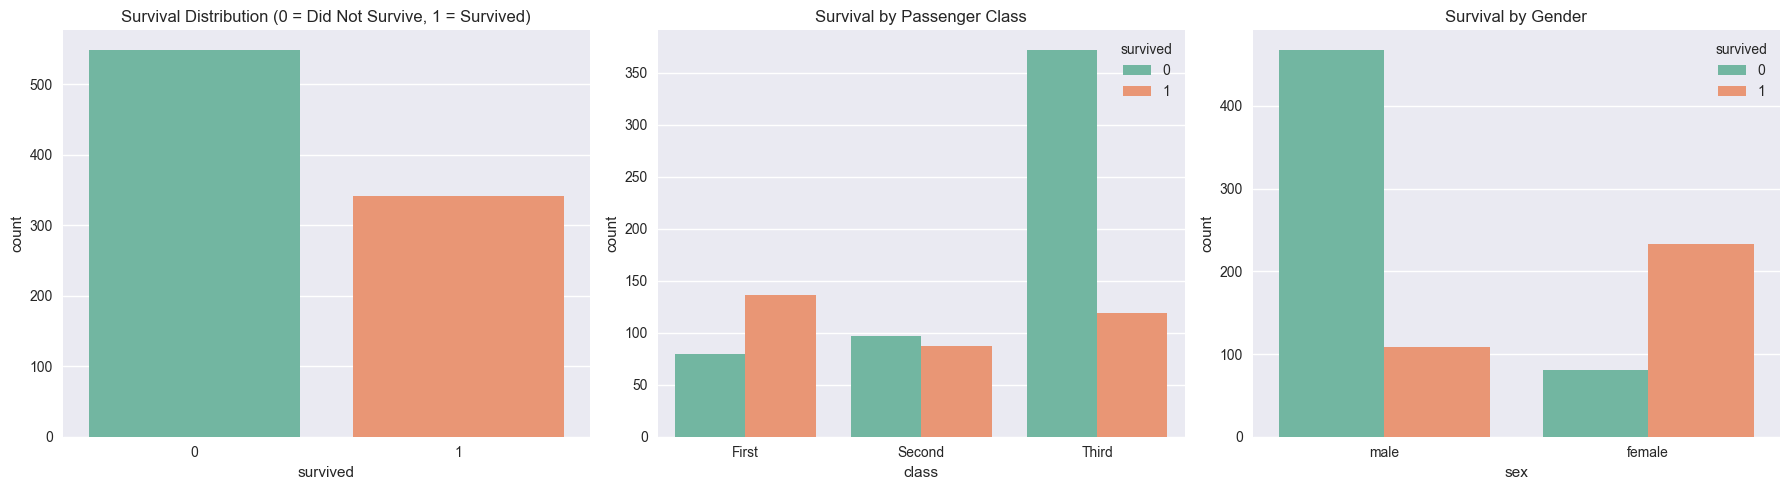

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

# 1. Overall Survival Distribution
sns.countplot(data=df, x="survived", hue="survived", palette="Set2", legend=False, ax=axes[0])
axes[0].set_title("Survival Distribution (0 = Did Not Survive, 1 = Survived)")

# 2. Survival by Passenger Class
sns.countplot(data=df, x="class", hue="survived", palette="Set2", ax=axes[1])
axes[1].set_title("Survival by Passenger Class")

# 3. Survival by Gender
sns.countplot(data=df, x="sex", hue="survived", palette="Set2", ax=axes[2])
axes[2].set_title("Survival by Gender")

plt.tight_layout()
plt.show()

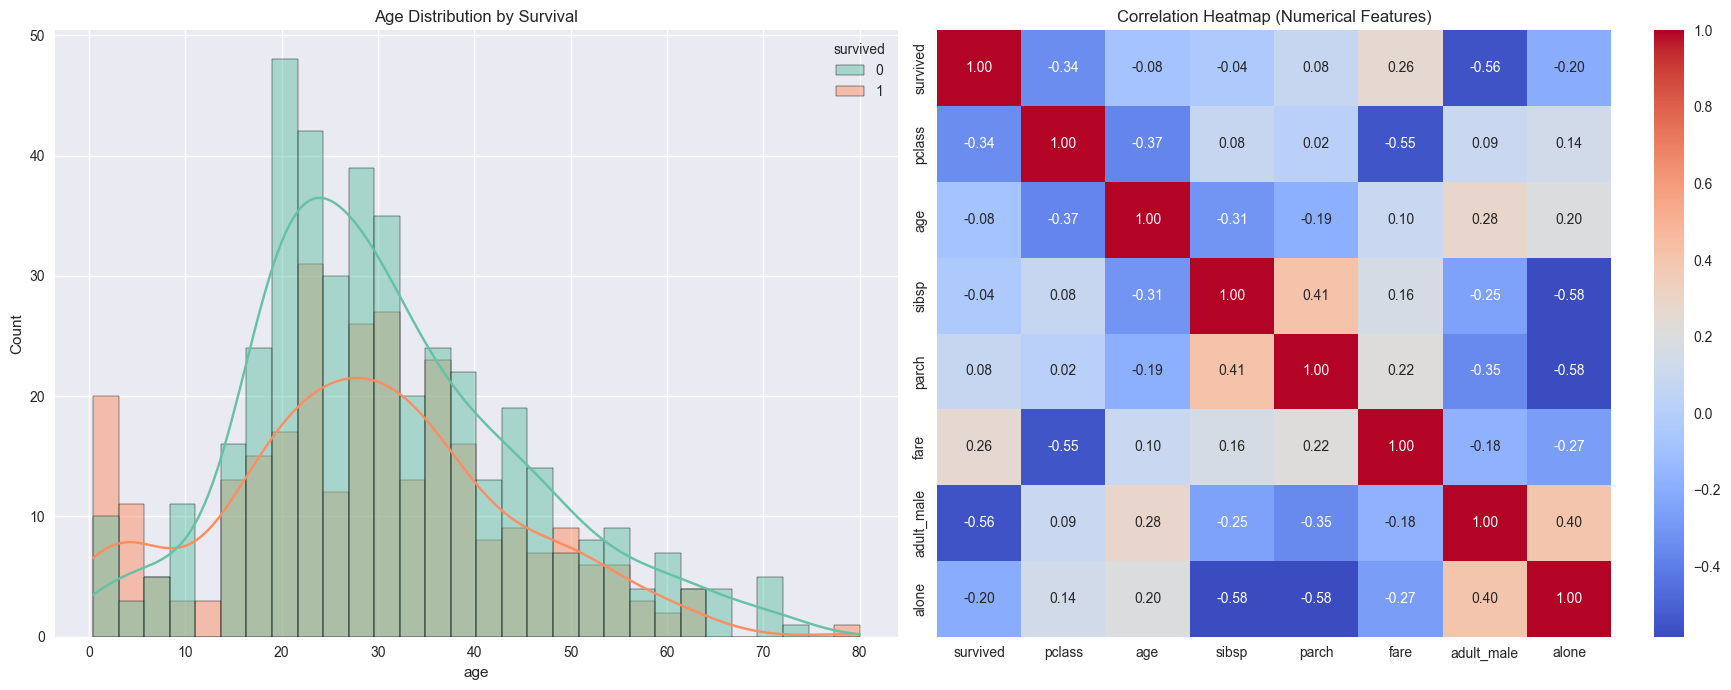

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
axes = axes.flatten()

# 4. Age Distribution with Survival Overlay
sns.histplot(data=df, x="age", hue="survived", bins=30, kde=True, palette="Set2", ax=axes[0])
axes[0].set_title("Age Distribution by Survival")

# 5. Correlation Heatmap
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=True)
axes[1].set_title("Correlation Heatmap (Numerical Features)")

plt.tight_layout()
plt.show()


## Data Preprocessing

Before training our models, we need to prepare the dataset.

### Preprocessing Steps:
1. **Select useful features**  
   - We will use: `pclass`, `sex`, `age`, `sibsp`, `parch`, `fare`, `embark_town`.  
   - Drop columns with too many missing values (e.g., `deck`) or irrelevant ones (`alive`, `who`, `adult_male`).

2. **Handle missing values**  
   - Fill missing `age` with median.  
   - Fill missing `embark_town` with mode (most common).  
   - Drop rows with missing `fare` (if any).

3. **Encode categorical variables**  
   - Convert `sex` and `embark_town` into numerical using **One-Hot Encoding**.

4. **Split data**  
   - Train/Test split (80/20).


In [6]:
# 1
features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embark_town"]
df_model = df[features + ["survived"]].copy()

# 2
df_model["age"] = df_model["age"].fillna(df_model["age"].median())
df_model["embark_town"] = df_model["embark_town"].fillna(df_model["embark_town"].mode()[0])
df_model = df_model.dropna(subset=["fare"])  # just in case

# 3
df_model = pd.get_dummies(df_model, columns=["sex", "embark_town"], drop_first=True)

# 4
X = df_model.drop("survived", axis=1)
y = df_model["survived"]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (712, 8)
Test set shape: (179, 8)


## **Train Tree-Based Models**

We will train three models on the Titanic dataset:

### 1. **Decision Tree Classifier** 

Decision Tree
Accuracy : 0.7653631284916201
Precision: 0.7547169811320755
Recall   : 0.5797101449275363
F1-score : 0.6557377049180327


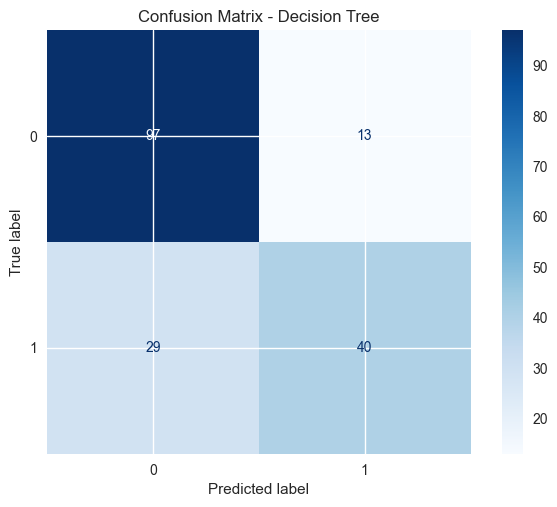

In [7]:
print("Decision Tree")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall   :", recall_score(y_test, y_pred_dt))
print("F1-score :", f1_score(y_test, y_pred_dt))

cm = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


### 2. **Random Forest Classifier**

Random Forest
Accuracy : 0.7821229050279329
Precision: 0.7884615384615384
Recall   : 0.5942028985507246
F1-score : 0.6776859504132231


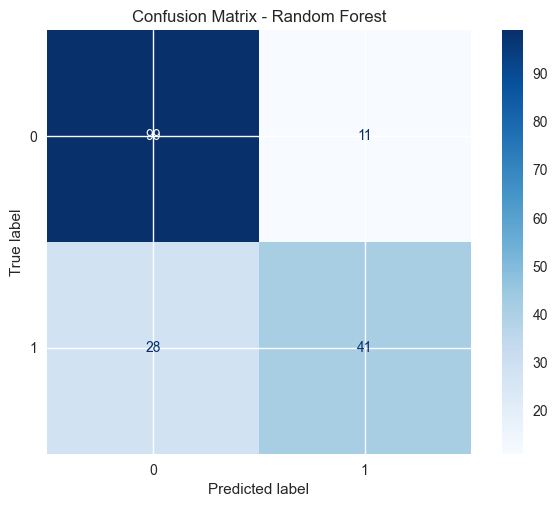

In [8]:
print("Random Forest")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1-score :", f1_score(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

### 3. **XGBoost Classifier**

XGBoost
Accuracy : 0.8156424581005587
Precision: 0.7727272727272727
Recall   : 0.7391304347826086
F1-score : 0.7555555555555555


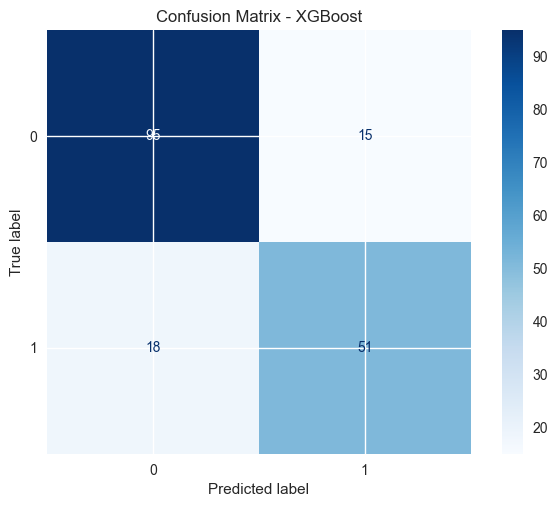

In [9]:
print("XGBoost")
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=5, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall   :", recall_score(y_test, y_pred_xgb))
print("F1-score :", f1_score(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()

## **Compare Models**

Now that we have trained three models (Decision Tree, Random Forest, XGBoost),  
let’s compare their performance side by side using key metrics:

- Accuracy  
- Precision  
- Recall  
- F1-score  

We will also create a bar plot to visualize the results.


In [10]:
results = {
    "Decision Tree": {
        "Accuracy": accuracy_score(y_test, y_pred_dt),
        "Precision": precision_score(y_test, y_pred_dt),
        "Recall": recall_score(y_test, y_pred_dt),
        "F1-score": f1_score(y_test, y_pred_dt),
    },
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1-score": f1_score(y_test, y_pred_rf),
    },
    "XGBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_xgb),
        "Precision": precision_score(y_test, y_pred_xgb),
        "Recall": recall_score(y_test, y_pred_xgb),
        "F1-score": f1_score(y_test, y_pred_xgb),
    }
}

results_df = pd.DataFrame(results).T
results_df


,Accuracy,Precision,Recall,F1-score
Decision Tree,0.765363,0.754717,0.579710,0.655738
Random Forest,0.782123,0.788462,0.594203,0.677686
XGBoost,0.815642,0.772727,0.739130,0.755556


<Figure size 1000x600 with 0 Axes>

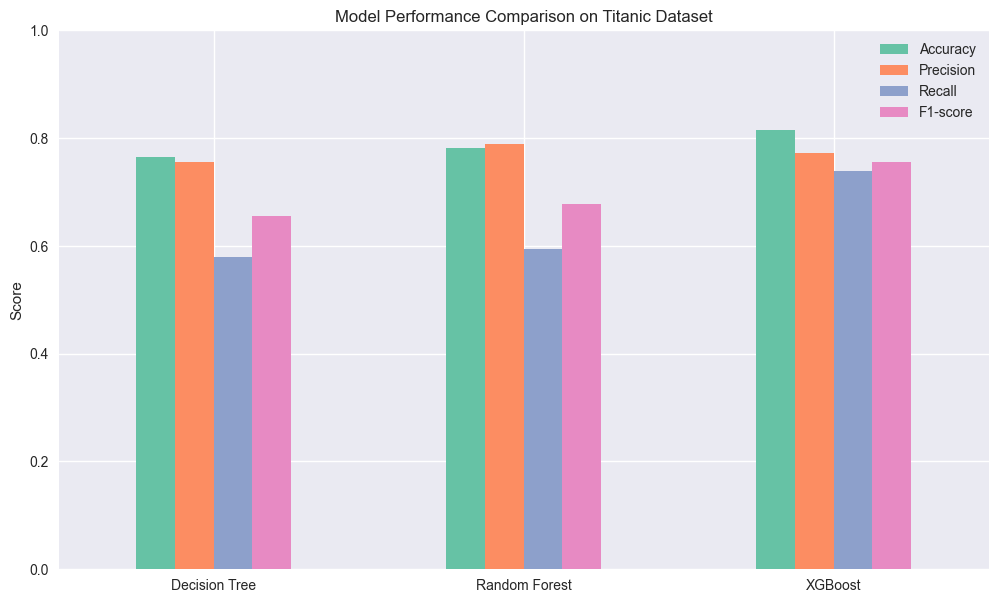

In [11]:
# Bar plot for comparison
plt.figure(figsize=(10,6))
results_df.plot(kind="bar", figsize=(12,7))
plt.title("Model Performance Comparison on Titanic Dataset")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()
